# Cell Size Distribution of Microbial Communities

In [1]:
import matplotlib.pyplot as p
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
import seaborn as sns
import sys
!conda install --yes --prefix {sys.prefix} sympy
from sympy import *
import scipy as sc
init_printing() # for pretty-printing equations etc
from scipy import integrate
import math

Solving environment: ...working... done

# All requested packages already installed.



### Basic Lotka-Volterra model for multiple species

The adapted equation of the Lotka-Volterra model is here:<br>
<br>
$\frac{dN}{dt} = N_{i}(r_{max,i} + \sum \limits _{j}a_{ij}N_{j})$<br>
Where $N_{i}$ is the total biomass of species i, $r_{max,i}$ is the maximal growth rate of species i and $a_{ij}$ is the per capita competitive effect of species j on species i. $r_{max}$ and $a_{ij}$ scale with the average mass of a bacterium of that species (more info later). $a_{ii}$ represents the inverse of the carrying capacity for species i, which is usually -1.

Parameter|Dimension|Possible Values
-----|-----|----- 
$N$|$M$|-
$r_{max}$|$T^{-1}$|$10^{-3}$ to $1$
$a_{ij}$|$M^{-1}$|$10^{-3}$ to $10^{3}$


In [2]:
#Solution at equilibrium (dN/dt = 0) for a 2-species system
r_m1, r_m2, N1, N2, a11, a12, a21, a22, t = var("r_m1, r_m2, N1, N2, a11, a12, a21, a22, t", real = True)
dN1_dt = N1*(r_m1 + a11*N1 + a12*N2)
dN2_dt = N2*(r_m2 + a21*N1 + a22*N2)

N1_eqlb = Eq(dN1_dt,0)
N2_eqlb = Eq(dN2_dt,0)

N1_eqlb_sol = solve(N1_eqlb, N2)
N2_eqlb_sol = solve(N2_eqlb, N1)

N1_eqlb_sol, N2_eqlb_sol

In [5]:
#define a function to calculate the sum in the equation
def sumf(Competition, Species, i):
    x = 0
    for j in range(len(Species)):
        x = x + Competition[i][j]*Species[j]
    return(x)

[[-1.          0.49963496 -0.45573036  0.30764114  0.01286522]
 [-0.42551304 -1.          0.09228769  0.36882879 -0.03010672]
 [-0.11416348 -0.00547781 -1.         -0.24967338  0.34024395]
 [ 0.05560146  0.05244078 -0.08329486 -1.         -0.44776327]
 [-0.01992566 -0.32860506  0.46403369 -0.03371221 -1.        ]]


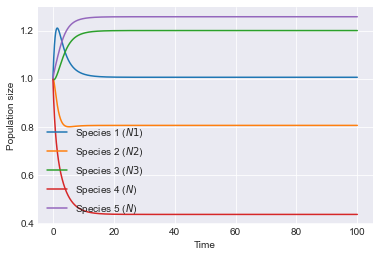

In [9]:
#parameters
t_vec = np.arange(0, 100., 0.01)
Species = 5 #number of species in the system
r_m = np.ones(Species) #max growth rate of each species
a = (random.rand(Species,Species)-0.5) #competition matrix
for i in range(5):
    a[i][i] = -1 #Diagonals = -1 (Carrying Capacity)

#initial condition
N10N20 = np.ones(Species)

#model and solution
def LV(N1N2, t, r_m2, a):
    dN_dt = np.empty(Species)
    for i in range(Species):
        dN_dt[i] = N1N2[i]*r_m[i]*(1 + sumf(a, N1N2, i))
    return dN_dt

N1N2_vec = integrate.odeint(LV, N10N20, t_vec, (r_m, a))

print(a)
#plot
p.style.use('seaborn-darkgrid')
p.plot(t_vec, N1N2_vec)
p.xlabel('Time')
p.ylabel('Population size')
p.legend(['Species 1 ($N1$)', 'Species 2 ($N2$)', 'Species 3 ($N3$)', 'Species 4 ($N$)', 'Species 5 ($N$)'], loc='best')

### Temperature-corrected Lotka-Volterra model with mass scaling

$\frac{dN}{dt} = N_{i}(Y_{0}m_{i}^{\alpha-1}e^{\frac{-E}{kT}} + \sum \limits _{j}a_{ij}(m_{i},T)N_{j})$<br>

Parameter|Dimension|Possible Values
-----|-----|----- 
$N$|$M$|-
$m$|$M$|~$10^{-12}$ g
$\alpha-1$|-|$0.8$
$Y_{0}$|$(TM)^{-1}$|$10^{18}$ to $10^{21}$ ?
$e^{\frac{-E}{kT}}$|-|$10^{-10}$ (for E = 0.6)?
$a_{ij}(m_{i},T)$|$M^{-1}$|$10^{-3}$ to $10^{3}$

According to DeLong the scaling exponent $\alpha$ for prokaryotes lies between 1.65 and 2.14 and not -0.75 like in vertebrates (Kleiber's Law). So, $\alpha-1$ would be between 0.65 and 1.14. Knowing $\alpha$ is important to determine the possible values of $Y_{0}$. <br>
If we assume that $0.6 < \alpha-1 < 1$, $m_{i}^{\alpha-1}$ lies between $10^{-8}$ and $10^{-11}$ and with the temperature correction being around $10^{-10}$, $Y_{0}$ has to be at least $10^{18}$ and $10^{21}$ to obtain a realistic growth rate (~1).

In [2]:
Tcorr = math.exp(-0.6/(8.62*10**(-5)*310)) #Temperature correction
print(Tcorr)

1.7725900001861085e-10


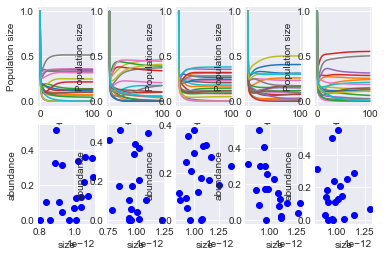

In [283]:
#define a function to calculate the sum in the equation
def sumf(Competition, Species, i):
    x = 0
    for j in range(len(Species)):
        x = x + Competition[i][j]*Species[j]
    return(x)

#model and solution
def LV(N1N2, t, Y0, m, alpha, Tcorr, a):
    dN_dt = np.empty(Species)
    for i in range(Species):
        dN_dt[i] = N1N2[i]*Y0*m[i]**(alpha-1)*Tcorr*(1 + sumf(a, N1N2, i))
    return dN_dt

#global Parameters
t_vec = np.arange(0, 100., 0.01)
Species = 20 #number of species in the system
Runs = 5 #number of simulations
Y0 = 1.5*10**18
alpha = 1.7
Tcorr = math.exp(-0.6/(8.62*10**(-5)*310))

p.style.use('seaborn-darkgrid')  
fig, axs = plt.subplots(2, Runs)
m_final = np.zeros([Runs, Species])
N1N2_final = np.zeros([Runs, Species])

for n in range(Runs): #run simulation multiple times
    #local Parameters
    m=random.normal(loc=1000, scale = 100, size=(Species))/(1000)*10**(-12) #random gaussian distributed mass of species ranging from 0.6*10^-12g to 1.4*10^-12g
    a = (random.rand(Species,Species)/2-0.5) #competition matrix
    for i in range(Species):
        a[i][i] = -1 #Diagonals = -1 (Carrying Capacity)

    #initial condition
    N10N20 = np.ones(Species)
    
    #ODE Solution and Plot
    N1N2_vec = integrate.odeint(LV, N10N20, t_vec, (Y0, m, alpha, Tcorr, a))
    axs[0,n].plot(t_vec, N1N2_vec)
    axs[0,n].set_xlabel('Time')
    axs[0,n].set_ylabel('Population size')
    
    #plot final size distribution
    axs[1,n].plot(m,N1N2_vec[10000-1],'bo')
    axs[1,n].set_xlabel('size')
    axs[1,n].set_ylabel('abundance')
    
    #save final size distribution in a cumulative array
    m_final[n] = m_final[n] + m
    N1N2_final[n] = N1N2_final[n] + N1N2_vec[10000-1]
    


##### Final size distribution:

Text(0, 0.5, 'abundance')

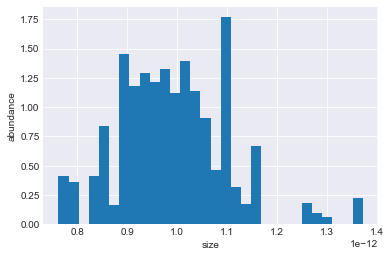

In [284]:
m_f = np.concatenate(m_final)
N_f = np.concatenate(N1N2_final)
results = np.zeros([100,2])
results[:,0] = m_f
results[:,1] = N_f
results_sorted = results[results[:, 1].argsort()] #sort sizes for abundance

x = 0
for i in range(len(results[:,1])):
    if results[i,1]<=10**(-5):
        x += 1

fig, ax = plt.subplots()
ax.hist(results_sorted[x:,0], bins=30, weights=results_sorted[x:,1])
ax.set_xlabel('size')
ax.set_ylabel('abundance')
